# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

In [2]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 5e-5  # Ajuste de tasa de aprendizaje inicial
LEARNING_RATE_FINE_TUNE = 5e-6  # Ajuste de tasa de aprendizaje para fine-tuning
BASE_MODEL = 'EfficientNetB0'

In [4]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [5]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [6]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

In [7]:
# =============================================
# GENERADOR DE DATOS
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [ ]:
# =============================================
# CONSTRUCCIÓN DEL MODELO CON AJUSTE FINO Y MEJORAS
# =============================================
# Last Execution 8:11:46 PM
# Execution Time 13m 22.2s
# Overhead Time 110ms
# Render Times
# VS Code Builtin Notebook Output Renderer 56ms

def build_multi_output_model_fine_tuning(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")

    # Congelar todas las capas inicialmente
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Reducido dropout para menos regularización

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )

    return model

# Construir modelo
model = build_multi_output_model_fine_tuning(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar para entrenamiento inicial
model.compile(
    optimizer=Adam(learning_rate=5e-5),  # tasa de aprendizaje inicial ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_fine_tuning.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial con base congelada
history_initial = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Descongelar últimas capas para ajuste fino
base_model = model.layers[1]  # Asumiendo que la segunda capa es el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 30 (más capas descongeladas)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje menor
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # tasa de aprendizaje para fine-tuning ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Entrenamiento con ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Guardar modelo final
model.save('final_model_fine_tuned_v2.keras')

2025-05-07 19:58:24.044824: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - dannos_accuracy: 0.1868 - dannos_loss: 0.7127 - loss: 2.1315 - partes_accuracy: 0.0426 - partes_loss: 0.7160 - sugerencias_accuracy: 0.5416 - sugerencias_loss: 0.7028
Epoch 1: val_loss improved from inf to 1.75894, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 786ms/step - dannos_accuracy: 0.1889 - dannos_loss: 0.7096 - loss: 2.1221 - partes_accuracy: 0.0443 - partes_loss: 0.7135 - sugerencias_accuracy: 0.5508 - sugerencias_loss: 0.6982 - val_dannos_accuracy: 0.2865 - val_dannos_loss: 0.5819 - val_loss: 1.7589 - val_partes_accuracy: 0.0760 - val_partes_loss: 0.6143 - val_sugerencias_accuracy: 0.8304 - val_sugerencias_loss: 0.5740
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - dannos_accuracy: 0.3111 - dannos_loss: 0.5530 - loss: 1.7368 - partes_accuracy: 0.0820 - partes_loss: 0.5904 - sugerencias_accuracy: 0.7940 - sugerencias_loss: 0.5963
Epoch 2: val_loss improved from 1.75894 to 1.54557, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - dannos_accuracy: 0.3112 - dannos_loss: 0.5522 - loss: 1.7344 - partes_accuracy: 0.0820 - partes_loss: 0.5893 - sugerencias_accuracy: 0.7940 - sugerencias_loss: 0.5959 - val_dannos_accuracy: 0.2924 - val_dannos_loss: 0.5163 - val_loss: 1.5456 - val_partes_accuracy: 0.0994 - val_partes_loss: 0.5170 - val_sugerencias_accuracy: 0.8655 - val_sugerencias_loss: 0.5247
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - dannos_accuracy: 0.3665 - dannos_loss: 0.4792 - loss: 1.5129 - partes_accuracy: 0.0891 - partes_loss: 0.4855 - sugerencias_accuracy: 0.8134 - sugerencias_loss: 0.5409
Epoch 3: val_loss improved from 1.54557 to 1.39567, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 740ms/step - dannos_accuracy: 0.3663 - dannos_loss: 0.4791 - loss: 1.5115 - partes_accuracy: 0.0895 - partes_loss: 0.4847 - sugerencias_accuracy: 0.8136 - sugerencias_loss: 0.5405 - val_dannos_accuracy: 0.3041 - val_dannos_loss: 0.4827 - val_loss: 1.3957 - val_partes_accuracy: 0.1170 - val_partes_loss: 0.4384 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.4883
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - dannos_accuracy: 0.3491 - dannos_loss: 0.4707 - loss: 1.3708 - partes_accuracy: 0.0895 - partes_loss: 0.4073 - sugerencias_accuracy: 0.8521 - sugerencias_loss: 0.4806
Epoch 4: val_loss improved from 1.39567 to 1.28453, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - dannos_accuracy: 0.3502 - dannos_loss: 0.4704 - loss: 1.3699 - partes_accuracy: 0.0901 - partes_loss: 0.4066 - sugerencias_accuracy: 0.8520 - sugerencias_loss: 0.4806 - val_dannos_accuracy: 0.3158 - val_dannos_loss: 0.4643 - val_loss: 1.2845 - val_partes_accuracy: 0.1637 - val_partes_loss: 0.3777 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.4569
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - dannos_accuracy: 0.4041 - dannos_loss: 0.4492 - loss: 1.2897 - partes_accuracy: 0.1148 - partes_loss: 0.3522 - sugerencias_accuracy: 0.8304 - sugerencias_loss: 0.4864
Epoch 5: val_loss improved from 1.28453 to 1.20317, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 777ms/step - dannos_accuracy: 0.4045 - dannos_loss: 0.4490 - loss: 1.2882 - partes_accuracy: 0.1155 - partes_loss: 0.3517 - sugerencias_accuracy: 0.8314 - sugerencias_loss: 0.4853 - val_dannos_accuracy: 0.3509 - val_dannos_loss: 0.4490 - val_loss: 1.2032 - val_partes_accuracy: 0.2222 - val_partes_loss: 0.3353 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.4333
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - dannos_accuracy: 0.4277 - dannos_loss: 0.4516 - loss: 1.1908 - partes_accuracy: 0.1357 - partes_loss: 0.3153 - sugerencias_accuracy: 0.8771 - sugerencias_loss: 0.4236
Epoch 6: val_loss improved from 1.20317 to 1.14499, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 701ms/step - dannos_accuracy: 0.4288 - dannos_loss: 0.4512 - loss: 1.1906 - partes_accuracy: 0.1358 - partes_loss: 0.3148 - sugerencias_accuracy: 0.8771 - sugerencias_loss: 0.4243 - val_dannos_accuracy: 0.3684 - val_dannos_loss: 0.4381 - val_loss: 1.1450 - val_partes_accuracy: 0.2807 - val_partes_loss: 0.3078 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.4140
Epoch 7/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - dannos_accuracy: 0.4722 - dannos_loss: 0.4230 - loss: 1.1514 - partes_accuracy: 0.1765 - partes_loss: 0.2866 - sugerencias_accuracy: 0.8573 - sugerencias_loss: 0.4419
Epoch 7: val_loss improved from 1.14499 to 1.10515, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - dannos_accuracy: 0.4720 - dannos_loss: 0.4231 - loss: 1.1500 - partes_accuracy: 0.1762 - partes_loss: 0.2862 - sugerencias_accuracy: 0.8581 - sugerencias_loss: 0.4404 - val_dannos_accuracy: 0.3860 - val_dannos_loss: 0.4298 - val_loss: 1.1052 - val_partes_accuracy: 0.2865 - val_partes_loss: 0.2893 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3999
Epoch 8/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - dannos_accuracy: 0.4844 - dannos_loss: 0.4056 - loss: 1.0790 - partes_accuracy: 0.1882 - partes_loss: 0.2702 - sugerencias_accuracy: 0.8660 - sugerencias_loss: 0.4031
Epoch 8: val_loss improved from 1.10515 to 1.07064, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - dannos_accuracy: 0.4833 - dannos_loss: 0.4069 - loss: 1.0798 - partes_accuracy: 0.1866 - partes_loss: 0.2703 - sugerencias_accuracy: 0.8663 - sugerencias_loss: 0.4036 - val_dannos_accuracy: 0.4444 - val_dannos_loss: 0.4213 - val_loss: 1.0706 - val_partes_accuracy: 0.2982 - val_partes_loss: 0.2765 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3875
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - dannos_accuracy: 0.5128 - dannos_loss: 0.3884 - loss: 1.0489 - partes_accuracy: 0.1756 - partes_loss: 0.2588 - sugerencias_accuracy: 0.8960 - sugerencias_loss: 0.3715
Epoch 9: val_loss improved from 1.07064 to 1.04791, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step - dannos_accuracy: 0.5123 - dannos_loss: 0.3888 - loss: 1.0497 - partes_accuracy: 0.1759 - partes_loss: 0.2589 - sugerencias_accuracy: 0.8954 - sugerencias_loss: 0.3722 - val_dannos_accuracy: 0.4152 - val_dannos_loss: 0.4154 - val_loss: 1.0479 - val_partes_accuracy: 0.2982 - val_partes_loss: 0.2677 - val_sugerencias_accuracy: 0.8655 - val_sugerencias_loss: 0.3798
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - dannos_accuracy: 0.5021 - dannos_loss: 0.3923 - loss: 1.0447 - partes_accuracy: 0.2230 - partes_loss: 0.2505 - sugerencias_accuracy: 0.8678 - sugerencias_loss: 0.3891
Epoch 10: val_loss improved from 1.04791 to 1.02798, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 695ms/step - dannos_accuracy: 0.5022 - dannos_loss: 0.3926 - loss: 1.0452 - partes_accuracy: 0.2221 - partes_loss: 0.2505 - sugerencias_accuracy: 0.8678 - sugerencias_loss: 0.3889 - val_dannos_accuracy: 0.4503 - val_dannos_loss: 0.4079 - val_loss: 1.0280 - val_partes_accuracy: 0.3041 - val_partes_loss: 0.2605 - val_sugerencias_accuracy: 0.8655 - val_sugerencias_loss: 0.3730
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - dannos_accuracy: 0.5499 - dannos_loss: 0.3953 - loss: 1.0175 - partes_accuracy: 0.1837 - partes_loss: 0.2479 - sugerencias_accuracy: 0.8719 - sugerencias_loss: 0.3767
Epoch 11: val_loss improved from 1.02798 to 1.01142, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 717ms/step - dannos_accuracy: 0.5491 - dannos_loss: 0.3957 - loss: 1.0175 - partes_accuracy: 0.1842 - partes_loss: 0.2479 - sugerencias_accuracy: 0.8722 - sugerencias_loss: 0.3767 - val_dannos_accuracy: 0.4561 - val_dannos_loss: 0.4026 - val_loss: 1.0114 - val_partes_accuracy: 0.3158 - val_partes_loss: 0.2550 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3666
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - dannos_accuracy: 0.5281 - dannos_loss: 0.3978 - loss: 1.0286 - partes_accuracy: 0.2072 - partes_loss: 0.2457 - sugerencias_accuracy: 0.8412 - sugerencias_loss: 0.3789
Epoch 12: val_loss improved from 1.01142 to 0.99683, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - dannos_accuracy: 0.5291 - dannos_loss: 0.3974 - loss: 1.0280 - partes_accuracy: 0.2077 - partes_loss: 0.2457 - sugerencias_accuracy: 0.8421 - sugerencias_loss: 0.3783 - val_dannos_accuracy: 0.4737 - val_dannos_loss: 0.3977 - val_loss: 0.9968 - val_partes_accuracy: 0.3216 - val_partes_loss: 0.2504 - val_sugerencias_accuracy: 0.8772 - val_sugerencias_loss: 0.3611
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - dannos_accuracy: 0.5066 - dannos_loss: 0.3725 - loss: 1.0031 - partes_accuracy: 0.2197 - partes_loss: 0.2493 - sugerencias_accuracy: 0.8723 - sugerencias_loss: 0.3627
Epoch 13: val_loss improved from 0.99683 to 0.98473, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 717ms/step - dannos_accuracy: 0.5071 - dannos_loss: 0.3728 - loss: 1.0030 - partes_accuracy: 0.2195 - partes_loss: 0.2494 - sugerencias_accuracy: 0.8722 - sugerencias_loss: 0.3627 - val_dannos_accuracy: 0.4737 - val_dannos_loss: 0.3929 - val_loss: 0.9847 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2466 - val_sugerencias_accuracy: 0.8772 - val_sugerencias_loss: 0.3580
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - dannos_accuracy: 0.5506 - dannos_loss: 0.3981 - loss: 0.9797 - partes_accuracy: 0.2325 - partes_loss: 0.2441 - sugerencias_accuracy: 0.8763 - sugerencias_loss: 0.3394
Epoch 14: val_loss improved from 0.98473 to 0.97207, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 759ms/step - dannos_accuracy: 0.5511 - dannos_loss: 0.3976 - loss: 0.9797 - partes_accuracy: 0.2322 - partes_loss: 0.2441 - sugerencias_accuracy: 0.8760 - sugerencias_loss: 0.3398 - val_dannos_accuracy: 0.5322 - val_dannos_loss: 0.3880 - val_loss: 0.9721 - val_partes_accuracy: 0.3275 - val_partes_loss: 0.2438 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3553
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_accuracy: 0.5885 - dannos_loss: 0.3630 - loss: 0.9316 - partes_accuracy: 0.2335 - partes_loss: 0.2438 - sugerencias_accuracy: 0.8911 - sugerencias_loss: 0.3221
Epoch 15: val_loss improved from 0.97207 to 0.96353, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - dannos_accuracy: 0.5883 - dannos_loss: 0.3633 - loss: 0.9326 - partes_accuracy: 0.2338 - partes_loss: 0.2437 - sugerencias_accuracy: 0.8907 - sugerencias_loss: 0.3227 - val_dannos_accuracy: 0.5088 - val_dannos_loss: 0.3835 - val_loss: 0.9635 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2409 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3521
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - dannos_accuracy: 0.5561 - dannos_loss: 0.3702 - loss: 0.9390 - partes_accuracy: 0.2543 - partes_loss: 0.2456 - sugerencias_accuracy: 0.8862 - sugerencias_loss: 0.3239
Epoch 16: val_loss improved from 0.96353 to 0.95785, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 711ms/step - dannos_accuracy: 0.5568 - dannos_loss: 0.3703 - loss: 0.9397 - partes_accuracy: 0.2546 - partes_loss: 0.2456 - sugerencias_accuracy: 0.8855 - sugerencias_loss: 0.3245 - val_dannos_accuracy: 0.5029 - val_dannos_loss: 0.3798 - val_loss: 0.9578 - val_partes_accuracy: 0.3392 - val_partes_loss: 0.2383 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3511
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - dannos_accuracy: 0.5405 - dannos_loss: 0.3621 - loss: 0.9620 - partes_accuracy: 0.2433 - partes_loss: 0.2429 - sugerencias_accuracy: 0.8796 - sugerencias_loss: 0.3325
Epoch 17: val_loss improved from 0.95785 to 0.94755, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - dannos_accuracy: 0.5408 - dannos_loss: 0.3620 - loss: 0.9613 - partes_accuracy: 0.2435 - partes_loss: 0.2426 - sugerencias_accuracy: 0.8795 - sugerencias_loss: 0.3324 - val_dannos_accuracy: 0.5439 - val_dannos_loss: 0.3758 - val_loss: 0.9475 - val_partes_accuracy: 0.3392 - val_partes_loss: 0.2359 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3491
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_accuracy: 0.5600 - dannos_loss: 0.3672 - loss: 0.9398 - partes_accuracy: 0.2246 - partes_loss: 0.2355 - sugerencias_accuracy: 0.8703 - sugerencias_loss: 0.3306
Epoch 18: val_loss improved from 0.94755 to 0.93993, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 715ms/step - dannos_accuracy: 0.5599 - dannos_loss: 0.3672 - loss: 0.9395 - partes_accuracy: 0.2257 - partes_loss: 0.2353 - sugerencias_accuracy: 0.8702 - sugerencias_loss: 0.3303 - val_dannos_accuracy: 0.5263 - val_dannos_loss: 0.3725 - val_loss: 0.9399 - val_partes_accuracy: 0.3450 - val_partes_loss: 0.2332 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3485
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - dannos_accuracy: 0.5665 - dannos_loss: 0.3592 - loss: 0.9447 - partes_accuracy: 0.2421 - partes_loss: 0.2443 - sugerencias_accuracy: 0.8532 - sugerencias_loss: 0.3365
Epoch 19: val_loss improved from 0.93993 to 0.93463, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - dannos_accuracy: 0.5669 - dannos_loss: 0.3591 - loss: 0.9438 - partes_accuracy: 0.2424 - partes_loss: 0.2442 - sugerencias_accuracy: 0.8540 - sugerencias_loss: 0.3357 - val_dannos_accuracy: 0.5439 - val_dannos_loss: 0.3700 - val_loss: 0.9346 - val_partes_accuracy: 0.3509 - val_partes_loss: 0.2313 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3473
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - dannos_accuracy: 0.6229 - dannos_loss: 0.3419 - loss: 0.8929 - partes_accuracy: 0.3027 - partes_loss: 0.2406 - sugerencias_accuracy: 0.8743 - sugerencias_loss: 0.3295
Epoch 20: val_loss improved from 0.93463 to 0.92669, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 725ms/step - dannos_accuracy: 0.6216 - dannos_loss: 0.3423 - loss: 0.8930 - partes_accuracy: 0.3020 - partes_loss: 0.2405 - sugerencias_accuracy: 0.8743 - sugerencias_loss: 0.3289 - val_dannos_accuracy: 0.5614 - val_dannos_loss: 0.3669 - val_loss: 0.9267 - val_partes_accuracy: 0.3626 - val_partes_loss: 0.2293 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3440
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_accuracy: 0.6105 - dannos_loss: 0.3431 - loss: 0.9003 - partes_accuracy: 0.2706 - partes_loss: 0.2286 - sugerencias_accuracy: 0.8676 - sugerencias_loss: 0.3231
Epoch 21: val_loss improved from 0.92669 to 0.92268, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - dannos_accuracy: 0.6102 - dannos_loss: 0.3431 - loss: 0.8995 - partes_accuracy: 0.2710 - partes_loss: 0.2285 - sugerencias_accuracy: 0.8681 - sugerencias_loss: 0.3221 - val_dannos_accuracy: 0.5380 - val_dannos_loss: 0.3640 - val_loss: 0.9227 - val_partes_accuracy: 0.3567 - val_partes_loss: 0.2274 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3435
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - dannos_accuracy: 0.5848 - dannos_loss: 0.3558 - loss: 0.9385 - partes_accuracy: 0.2728 - partes_loss: 0.2311 - sugerencias_accuracy: 0.8494 - sugerencias_loss: 0.3420
Epoch 22: val_loss improved from 0.92268 to 0.91592, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 723ms/step - dannos_accuracy: 0.5847 - dannos_loss: 0.3552 - loss: 0.9373 - partes_accuracy: 0.2731 - partes_loss: 0.2307 - sugerencias_accuracy: 0.8501 - sugerencias_loss: 0.3409 - val_dannos_accuracy: 0.5556 - val_dannos_loss: 0.3607 - val_loss: 0.9159 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2259 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3433
Epoch 23/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - dannos_accuracy: 0.6191 - dannos_loss: 0.3423 - loss: 0.8751 - partes_accuracy: 0.2761 - partes_loss: 0.2216 - sugerencias_accuracy: 0.8674 - sugerencias_loss: 0.3195
Epoch 23: val_loss did not improve from 0.91592
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 706ms/step - dannos_accuracy: 0.6185 - dannos_loss: 0.3428 - loss: 0.8752 - partes_accuracy: 0.2763 - partes_loss: 0.2218 - sugerencias_accuracy: 0.8676 - sugerencias_loss: 0.3191 - val_dannos_accuracy: 0.5556 - val_dannos_loss: 0.3600 - val_loss: 0.9166 - val_partes_accuracy: 0.3860 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - dannos_accuracy: 0.5951 - dannos_loss: 0.3355 - loss: 0.8702 - partes_accuracy: 0.2919 - partes_loss: 0.2211 - sugerencias_accuracy: 0.8761 - sugerencias_loss: 0.3040 - val_dannos_accuracy: 0.5789 - val_dannos_loss: 0.3566 - val_loss: 0.9078 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2228 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3421
Epoch 25/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - dannos_accuracy: 0.6358 - dannos_loss: 0.3209 - loss: 0.8771 - partes_accuracy: 0.3010 - partes_loss: 0.2257 - sugerencias_accuracy: 0.8608 - sugerencias_loss: 0.3272
Epoch 25: val_loss improved from 0.90779 to 0.90172, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 713ms/step - dannos_accuracy: 0.6350 - dannos_loss: 0.3214 - loss: 0.8772 - partes_accuracy: 0.3008 - partes_loss: 0.2256 - sugerencias_accuracy: 0.8610 - sugerencias_loss: 0.3269 - val_dannos_accuracy: 0.5789 - val_dannos_loss: 0.3542 - val_loss: 0.9017 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2215 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3409
Epoch 26/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - dannos_accuracy: 0.6403 - dannos_loss: 0.3277 - loss: 0.8597 - partes_accuracy: 0.2989 - partes_loss: 0.2249 - sugerencias_accuracy: 0.8907 - sugerencias_loss: 0.3043
Epoch 26: val_loss improved from 0.90172 to 0.89990, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 709ms/step - dannos_accuracy: 0.6398 - dannos_loss: 0.3277 - loss: 0.8598 - partes_accuracy: 0.2990 - partes_loss: 0.2246 - sugerencias_accuracy: 0.8904 - sugerencias_loss: 0.3040 - val_dannos_accuracy: 0.5731 - val_dannos_loss: 0.3527 - val_loss: 0.8999 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2203 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3400
Epoch 27/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - dannos_accuracy: 0.5891 - dannos_loss: 0.3420 - loss: 0.8755 - partes_accuracy: 0.3108 - partes_loss: 0.2227 - sugerencias_accuracy: 0.8693 - sugerencias_loss: 0.3296
Epoch 27: val_loss did not improve from 0.89990
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - dannos_accuracy: 0.5901 - dannos_loss: 0.3419 - loss: 0.8751 - partes_accuracy: 0.3105 - partes_loss: 0.2226 - sugerencias_accuracy: 0.8696 - sugerencias_loss: 0.3297 - val_dannos_accuracy: 0.5673 - val_dannos_loss: 0.3515 - val_loss: 0.9033 - val_partes_accuracy: 0.3801 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - dannos_accuracy: 0.6149 - dannos_loss: 0.3169 - loss: 0.8229 - partes_accuracy: 0.2842 - partes_loss: 0.2149 - sugerencias_accuracy: 0.8447 - sugerencias_loss: 0.2840 - val_dannos_accuracy: 0.5789 - val_dannos_loss: 0.3481 - val_loss: 0.8951 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2172 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3427
Epoch 29/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - dannos_accuracy: 0.6187 - dannos_loss: 0.3306 - loss: 0.8078 - partes_accuracy: 0.3124 - partes_loss: 0.2210 - sugerencias_accuracy: 0.9045 - sugerencias_loss: 0.2549
Epoch 29: val_loss improved from 0.89509 to 0.88896, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 727ms/step - dannos_accuracy: 0.6184 - dannos_loss: 0.3307 - loss: 0.8094 - partes_accuracy: 0.3119 - partes_loss: 0.2210 - sugerencias_accuracy: 0.9037 - sugerencias_loss: 0.2564 - val_dannos_accuracy: 0.5906 - val_dannos_loss: 0.3455 - val_loss: 0.8890 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2158 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3418
Epoch 30/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - dannos_accuracy: 0.6298 - dannos_loss: 0.3353 - loss: 0.8444 - partes_accuracy: 0.3022 - partes_loss: 0.2179 - sugerencias_accuracy: 0.8545 - sugerencias_loss: 0.3121
Epoch 30: val_loss improved from 0.88896 to 0.88612, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 711ms/step - dannos_accuracy: 0.6297 - dannos_loss: 0.3354 - loss: 0.8443 - partes_accuracy: 0.3023 - partes_loss: 0.2179 - sugerencias_accuracy: 0.8551 - sugerencias_loss: 0.3128 - val_dannos_accuracy: 0.6199 - val_dannos_loss: 0.3434 - val_loss: 0.8861 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2146 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3444
Restoring model weights from the end of the best epoch: 30.
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - dannos_accuracy: 0.6048 - dannos_loss: 0.4562 - loss: 1.2269 - partes_accuracy: 0.3089 - partes_loss: 0.3362 - sugerencias_accuracy: 0.7916 - sugerencias_loss: 0.4415
Epoch 1: val_loss did not improve from 0.88612
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 837ms/step - dannos_accuracy: 0.6040 - dannos_loss: 0.4564 - loss: 1.2273 - partes_accuracy: 0.3084 - partes_loss: 0.3363 - sugerencias_accuracy: 0.7911 - sugerencias_loss: 0.4423 - val_dannos_accuracy: 0.6257 - val_dannos_loss: 0.34

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 22)        │     11,286 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,055,679 (34.54 MB)

 Trainable params: 2,167,422 (8.27 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

 Optimizer params: 4,334,846 (16.54 MB)

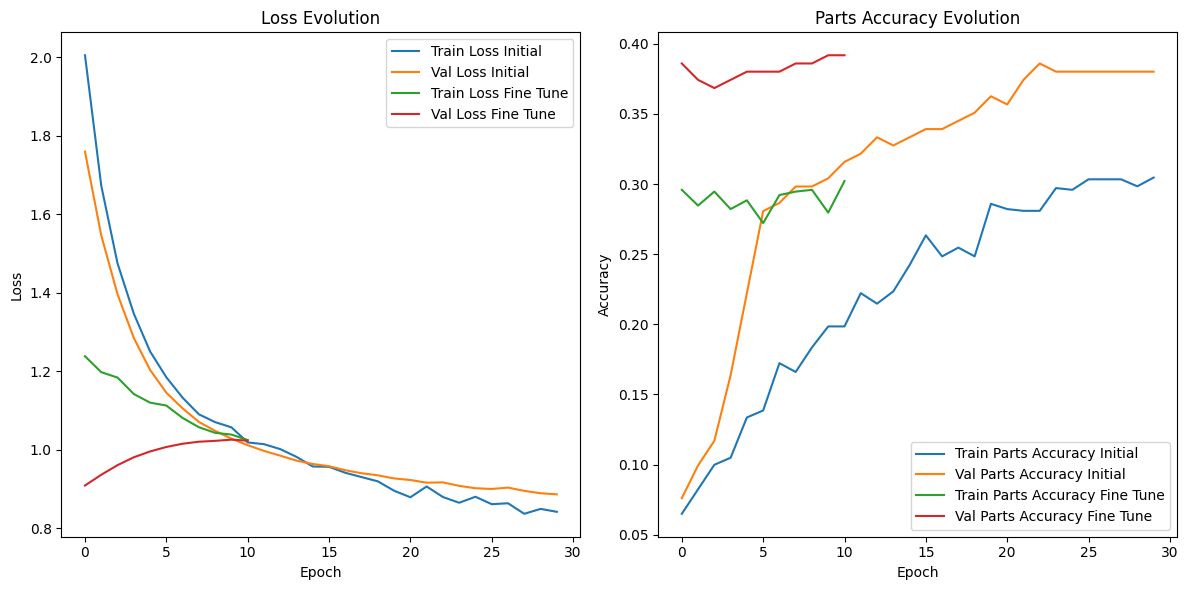

In [10]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

In [11]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")

    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5

    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])

    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))

    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))

    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))

    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - dannos_accuracy: 0.5672 - dannos_loss: 0.3618 - loss: 0.9114 - partes_accuracy: 0.3179 - partes_loss: 0.2196 - sugerencias_accuracy: 0.8959 - sugerencias_loss: 0.3288
Pérdida total: 0.923892617225647
Pérdida partes: 0.2277960330247879 - Accuracy partes: 0.5780346989631653
Pérdida daños: 0.37593626976013184 - Accuracy daños: 0.3352601230144501
Pérdida sugerencias: 0.3159211575984955 - Accuracy sugerencias: 0.8959537744522095

Generando predicciones...
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step

Reporte para Partes:
                                  precision    recall  f1-score   support

                            Capó       0.00      0.00      0.00        12
                   Faros derecho       0.00      0.00      0.00        11
                 Faros izquierdo       0.00      0.00      0.00         9
  Guardabarros delantero derecho       0.00      0.00      0.00        16
Guardabarros delantero izquierdo       0.00      0.00      0.00        1

In [12]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [13]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step

Predicciones para la imagen:

Partes:
- Parachoques delantero: 34.54% de probabilidad
- Rueda: 34.46% de probabilidad
- Parachoques trasero: 32.51% de probabilidad

Dannos:
- Abolladura: 49.58% de probabilidad
- Rotura: 44.39% de probabilidad
- Desprendimiento: 18.91% de probabilidad

Sugerencias:
- Reparar: 79.86% de probabilidad
- Reemplazar: 33.58% de probabilidad


In [16]:
# Ruta a la imagen de prueba
image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


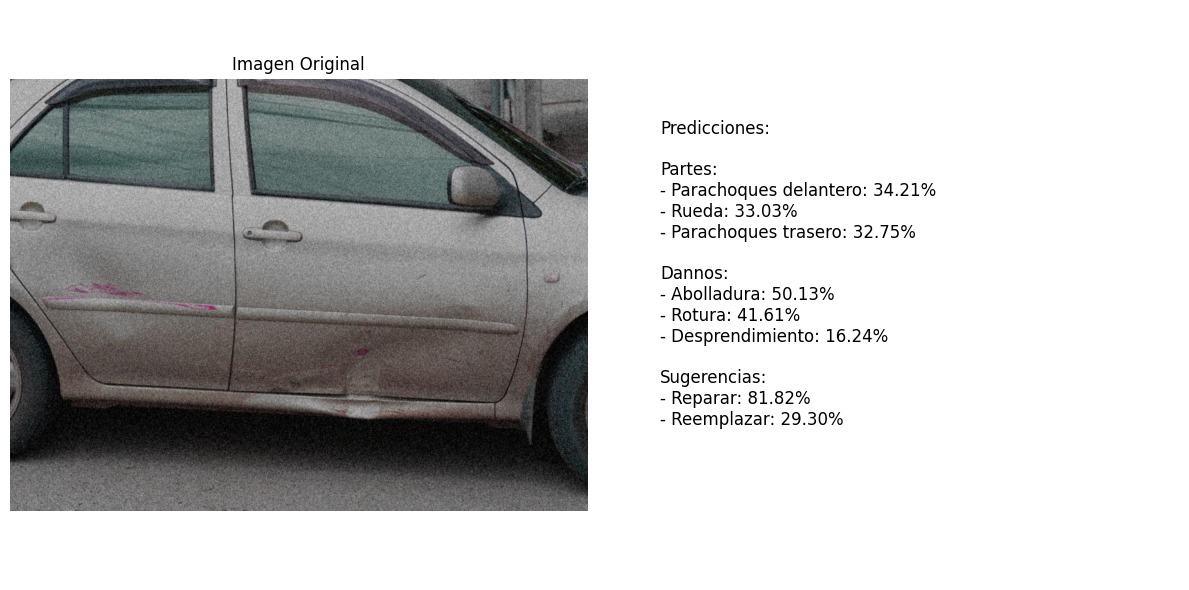

Resultados guardados en evaluation_results_fine_tuning.json


In [17]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

In [18]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json
